In [3]:
import torch
import numpy as np
import os, sys, glob, copy
import matplotlib.pyplot as plt
import PIL.Image as Image
sys.path.insert(0, "/home/cfoley_waller/defocam/SpectralDefocusCam")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import train
import utils.helper_functions as helper
import utils.diffuser_utils as diffuser_utils
import dataset.precomp_dataset as ds
from models.get_model import get_model

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [25]:
exp_meas_path = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/exp_meas/hatoncar"
config_path = "/home/cfoley_waller/defocam/defocuscamdata/models/checkpoint_train_02_07_2024_lsi_adjoint_batchnorm_L1psf_noiseaug.yml/2024_03_06_01_13_01/training_config.yml" 
trained_weights_path = "/home/cfoley_waller/defocam/defocuscamdata/models/checkpoint_train_02_07_2024_lsi_adjoint_batchnorm_L1psf_noiseaug.yml/2024_03_06_01_13_01/saved_model_ep369_testloss_0.08475265066538538.pt"

In [4]:
config = helper.read_config(config_path)
num_ims = config["forward_model_params"]["stack_depth"]
config["device"] = "cuda:3"
device = torch.device(config["device"])
print(torch.cuda.get_device_name(device))
a = torch.tensor([1], device = config['device'])

NVIDIA TITAN Xp


In [5]:
config["forward_model_params"]["psf"]

{'exposures': [0.00151, 0.00909, 0.02222, 0.03333, 0.04761],
 'largest_psf_diam': 128,
 'lri': False,
 'norm': 'one',
 'optimize': False,
 'padded_shape': [768, 768],
 'stride': 1,
 'symmetric': True,
 'threshold': 0.2}

In [6]:
config["data_precomputed"] = False
config["preload_weights"] = True
config["checkpoint_dir"] = trained_weights_path

model = train.get_model(config=config, device=device)
model.eval()
print(f"Model using: {torch.cuda.get_device_name(device)}")

print(model.model1.passthrough)
model.model1.operations

Reading psf: 100%|██████████| 5/5 [00:00<00:00, 35.15it/s]


Scaled psfs by values: [1.0, 0.16611661166116612, 0.06795679567956796, 0.045304530453045305, 0.03171602604494854]
Model using: NVIDIA TITAN Xp
False


{'adj_mask_noise': True,
 'adjoint': True,
 'fwd_mask_noise': True,
 'sim_blur': False,
 'sim_meas': True,
 'spectral_pad': True}

In [7]:
train_loader, val_loader, test_loader = ds.get_data_precomputed(
    batch_size=config["batch_size"],
    data_split=config["data_partition"],
    base_path=config["base_data_path"],
    model_params=config["forward_model_params"],
    norm_target = False,
    shuffle = False,
    workers = 6,
)
sample = test_loader.dataset[0]
gt = sample['image'].cpu().numpy()
sim = sample['input'].cpu().numpy()

In [8]:
helper.plot_cube_interactive(np.transpose(gt, (1,2,0)))

FigureWidget({
    'data': [{'type': 'image',
              'uid': '22fc3c9d-2bc2-4643-9a8b-a9d54847ec1e',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[102, 111,  50],
                           [112, 122,  57],
                           [123, 131,  50],
                           ..., 
                           [154, 166,  72],
                           [145, 155,  67],
                           [133, 143,  60]],
                   
                          [[106, 113,  42],
                           [108, 118,  53],
                           [128, 140,  57],
                           ..., 
                           [161, 176,  83],
                           [153, 166,  67],
                           [147, 158,  74]],
                   
                          [[119, 127,  53],
                           [110, 118,  49],
                           [120, 130,  60],
                           ..., 
                           [155, 170

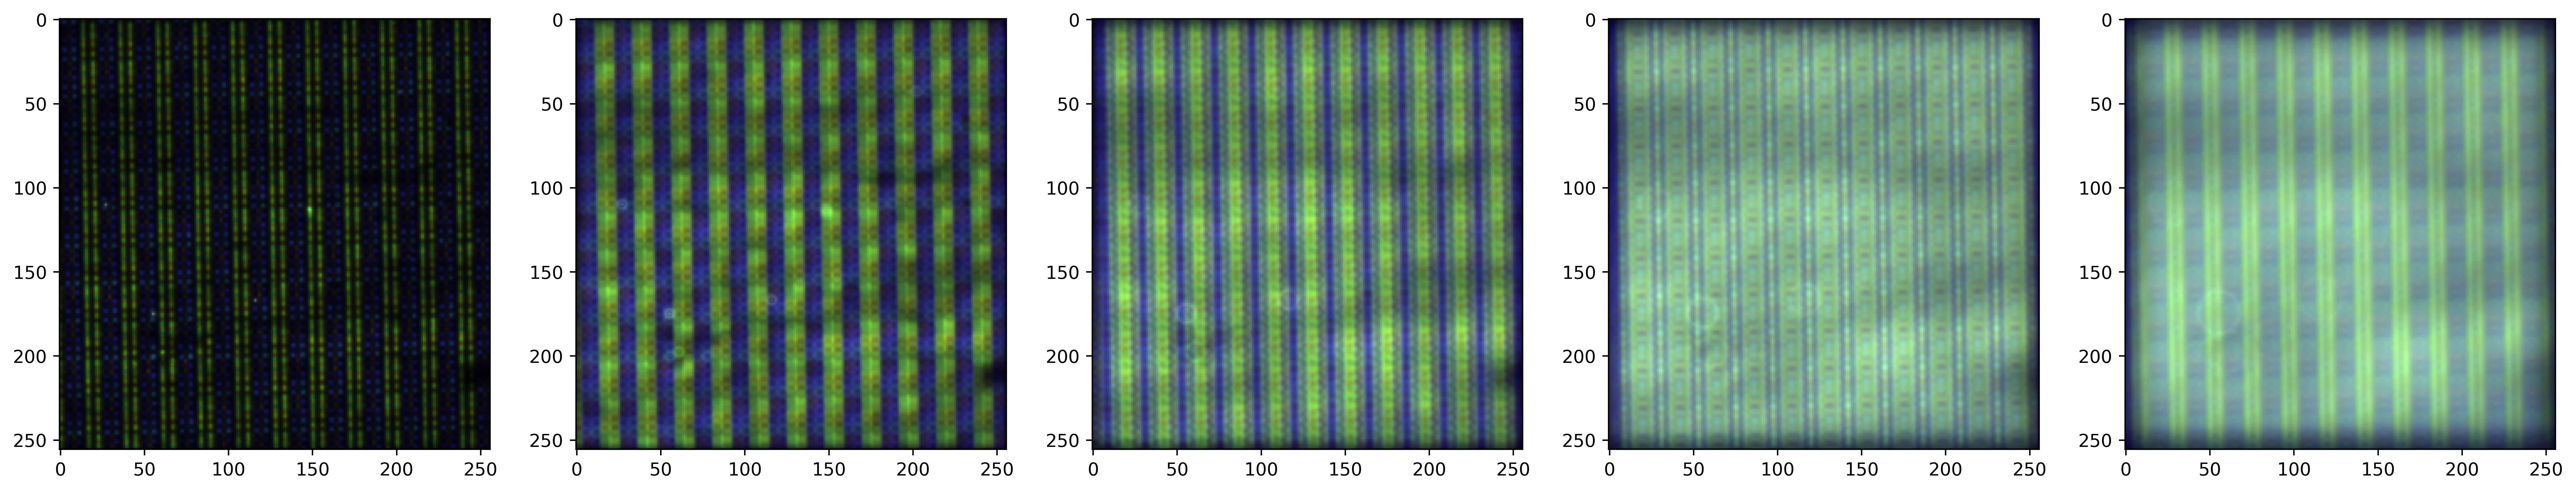

In [ ]:
fig, ax = plt.subplots(1, sim.shape[0], figsize = (sim.shape[0]*5, 5))
for i in range(sim.shape[0]):
    im = sim[0,i]
    ax[i].imshow(helper.value_norm(helper.stack_rgb_opt_30(np.transpose(sim[i,1:-1], (1,2,0)))))
plt.show()

In [9]:
pred = model.model2(torch.tensor(sim).to(device)[None,...])[:,1:-1]
print(pred.shape)
pred = pred * gt.std() + gt.mean()

helper.plot_cube_interactive(np.transpose(pred.detach().cpu().numpy()[0], (1,2,0)))


torch.Size([1, 30, 256, 256])


FigureWidget({
    'data': [{'type': 'image',
              'uid': '2f444aaf-5be5-46b8-9375-87b5da3a46c9',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[158, 177,  81],
                           [126, 142,  54],
                           [124, 140,  54],
                           ..., 
                           [150, 166,  65],
                           [149, 166,  67],
                           [171, 191,  85]],
                   
                          [[122, 138,  49],
                           [115, 131,  34],
                           [115, 133,  40],
                           ..., 
                           [148, 168,  59],
                           [146, 166,  58],
                           [152, 172,  65]],
                   
                          [[122, 136,  45],
                           [119, 135,  36],
                           [118, 135,  41],
                           ..., 
                           [144, 167

# ONE NORM FORWARD & NO NORM ADJOINT

In [25]:
fm = get_model(config, device, fwd_only=True)

Reading psf: 100%|██████████| 5/5 [00:00<00:00, 66.90it/s]


Scaled psfs by values: [1.0, 0.16611661166116612, 0.06795679567956796, 0.045304530453045305, 0.03171602604494854]


In [26]:
gt2 = torch.tensor(np.expand_dims(sample["image"], 0)).to(
    fm.device
)[None,...]
print(gt2.shape)

print(gt.mean(), gt.std())

torch.Size([1, 1, 30, 256, 256])
84.6327 28.8919


In [27]:
fm.mask.mean()

tensor(0.0368, device='cuda:1')

In [28]:
# 1 norm
one_norm = fm.psfs.sum(dim=(-2, -1), keepdim=True)
# 2 norm
two_norm = fm.psfs.norm(dim=(-2, -1), keepdim=True)

sim2 = fm.fwd(gt2, fm.psfs, fm.mask)
print(sim2.mean(), sim2.std(), sim2.shape)

tensor(89.6733, device='cuda:1', dtype=torch.float64) tensor(57.9579, device='cuda:1', dtype=torch.float64) torch.Size([1, 5, 1, 256, 256])


In [29]:
adj2 = fm.adj(sim2, fm.psfs, fm.mask)
print(adj2.mean(), adj2.std(), adj2.shape)

tensor(4.1759, device='cuda:1', dtype=torch.float64) tensor(4.8735, device='cuda:1', dtype=torch.float64) torch.Size([1, 5, 30, 256, 256])


In [30]:
torch.cuda.empty_cache()

In [32]:
adj2_norm = fm.spectral_pad(adj2_norm, spec_dim=-3, size=2)

In [33]:
norm = ds.Normalize(0,1)

adj2_norm = norm(adj2_norm).float()
print(adj2_norm.mean(), adj2_norm.std(), adj2_norm.shape)

tensor(3.7253e-10, device='cuda:1') tensor(1., device='cuda:1') torch.Size([1, 5, 32, 256, 256])


In [34]:
pred2 = model.model2(adj2_norm.to(device))[:,1:-1]
print(pred2.shape)

torch.Size([1, 30, 256, 256])


In [35]:
pred2.mean(), pred2.std()

(tensor(-0.1335, device='cuda:1', grad_fn=<MeanBackward0>),
 tensor(0.6258, device='cuda:1', grad_fn=<StdBackward0>))

In [36]:
helper.plot_cube_interactive(np.transpose(pred2.detach().cpu().numpy()[0], (1,2,0)))

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'ff38ab76-8c61-41c4-96ba-553fb32588d7',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 64,  65,  95],
                           [ 54,  55,  91],
                           [ 50,  50,  89],
                           ..., 
                           [112, 118, 110],
                           [116, 122, 116],
                           [ 89,  91, 102]],
                   
                          [[ 53,  52,  89],
                           [ 43,  41,  84],
                           [ 32,  29,  76],
                           ..., 
                           [113, 120, 111],
                           [116, 124, 118],
                           [108, 113, 115]],
                   
                          [[ 46,  44,  82],
                           [ 33,  31,  74],
                           [ 24,  18,  66],
                           ..., 
                           [100, 105

# Now experiment

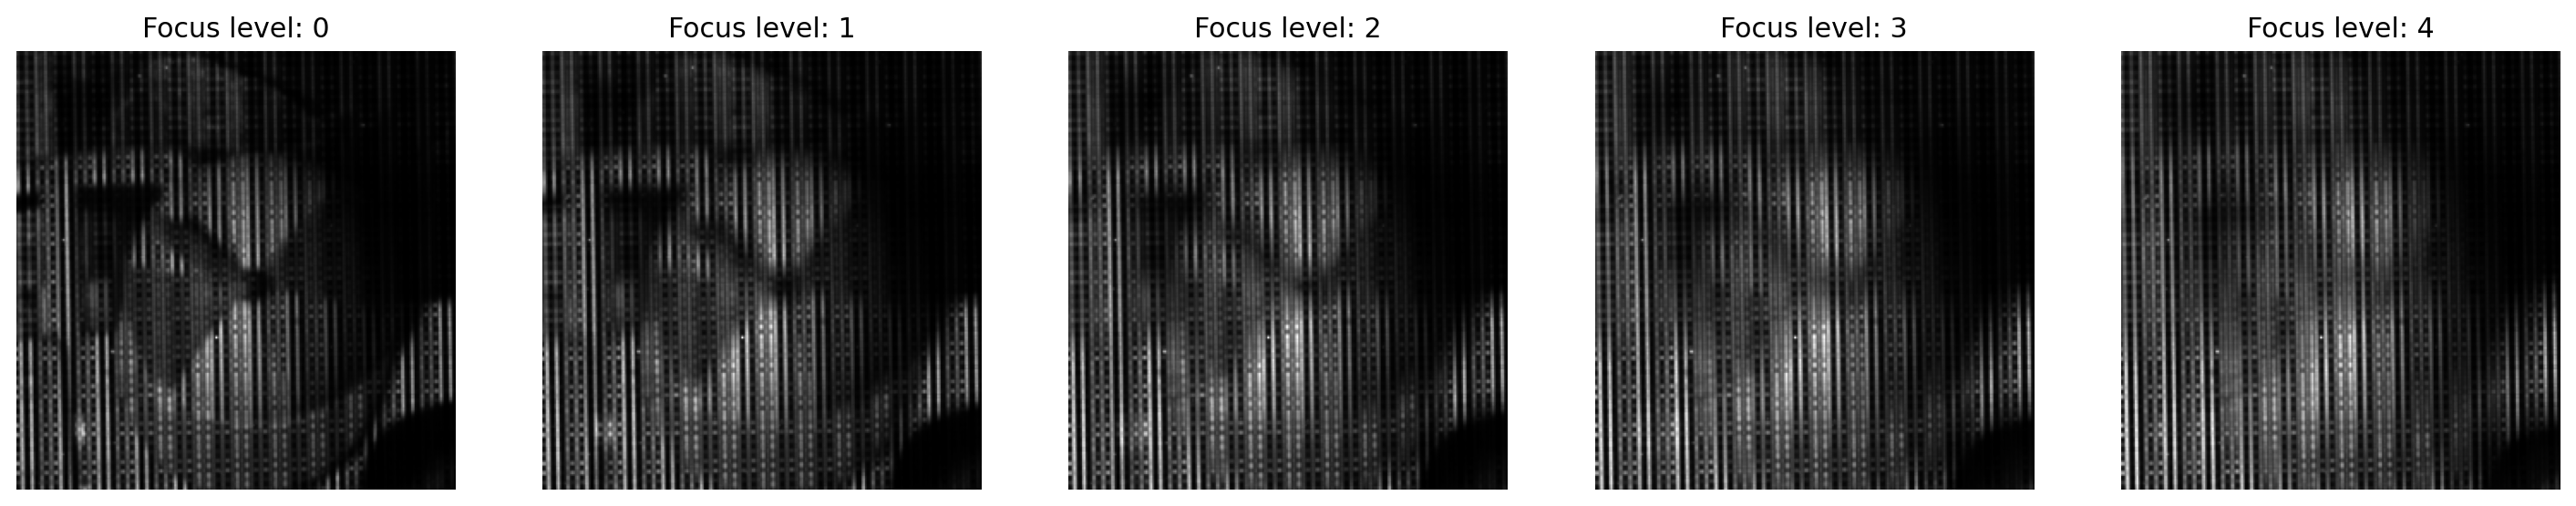

In [11]:
def preprocess_exp_meas(meas, config):
    # read
    center = config["image_center"]
    dim = config["patch_crop"][0]
    crop = lambda x: x[center[0] -dim//2:center[0]+dim//2, center[1]-dim//2: center[1]+dim//2]
    meas =  crop(np.array(Image.open(meas), dtype=float))

    # downsample
    meas = diffuser_utils.pyramid_down(meas, config["patch_size"])

    #one-normalize
    #meas = (meas - np.min(meas))/(np.max(meas - np.min(meas)))
    return meas

exp_meas = [preprocess_exp_meas(m, config) for m in sorted(glob.glob(os.path.join(exp_meas_path, "*.bmp")))][:num_ims]

fig, ax = plt.subplots(1, len(exp_meas), figsize = (4*len(exp_meas), 4))
fig.set_dpi(180)
for i,meas in enumerate(exp_meas):
    ax[i].imshow(exp_meas[i], cmap='gray')
    ax[i].set_title(f"Focus level: {i}")
    ax[i].axis('off')
plt.show()

In [12]:
fm = get_model(config, device, fwd_only=True)
exp_meas_stack = torch.tensor(np.stack(exp_meas)).to(device)[None, :, None, ...]
print(exp_meas_stack.mean(), exp_meas_stack.std(), exp_meas_stack.shape)

Reading psf: 100%|██████████| 5/5 [00:00<00:00, 55.20it/s]


Scaled psfs by values: [1.0, 0.16611661166116612, 0.06795679567956796, 0.045304530453045305, 0.03171602604494854]
tensor(23.3460, device='cuda:3', dtype=torch.float64) tensor(12.2825, device='cuda:3', dtype=torch.float64) torch.Size([1, 5, 1, 256, 256])


In [13]:
exp_adj = fm.adj(exp_meas_stack, fm.psfs, fm.mask)
print(exp_adj.mean(), exp_adj.std(), exp_adj.shape)

tensor(0.5972, device='cuda:3', dtype=torch.float64) tensor(0.4317, device='cuda:3', dtype=torch.float64) torch.Size([1, 5, 30, 256, 256])


In [14]:
exp_adj = fm.spectral_pad(exp_adj, spec_dim=-3, size=2)

In [15]:
norm = ds.Normalize(0,1)

exp_adj = norm(exp_adj).float()
print(exp_adj.mean(), exp_adj.std(), exp_adj.shape)

tensor(5.5879e-10, device='cuda:3') tensor(1.0000, device='cuda:3') torch.Size([1, 5, 32, 256, 256])


In [16]:
exp_pred = model.model2(exp_adj.to(device))[:,1:-1]
print(exp_pred.shape)

torch.Size([1, 30, 256, 256])


In [17]:
helper.plot_cube_interactive(np.transpose(exp_pred.detach().cpu().numpy()[0], (1,2,0)))

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'c99c2391-80f1-4ec9-880c-40fcb3692ef0',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[62, 59, 56],
                           [39, 31, 36],
                           [36, 26, 33],
                           ..., 
                           [16, 11, 26],
                           [19, 15, 29],
                           [42, 39, 46]],
                   
                          [[35, 29, 37],
                           [30, 22, 29],
                           [28, 19, 28],
                           ..., 
                           [12,  8, 23],
                           [13,  9, 24],
                           [20, 16, 30]],
                   
                          [[28, 22, 33],
                           [25, 17, 27],
                           [23, 15, 26],
                           ..., 
                           [11,  7, 23],
                           [12,  8, 24],

: 